In [1]:
import pandas as pd
import numpy as np
from resampling import time_resampling


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
###### Aplicação da Função para resampling da base de dados, deixando em formato horário. #################
###### Arquivo da Função: resampling.py
###########################################################################################################
df0= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2010.csv','1D')
df1= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2011.csv','1D')
df2= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2012.csv','1D')
df3= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2013.csv','1D')
df4= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2014.csv','1D')
df5= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2015.csv','1D')
df6= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2016.csv','1D')
df7= time_resampling('C:/Users/gusta/Google Drive/dados_desafio/2017.csv','1D')
#########################################################################,'1D'###################################

In [3]:
##### Concatenando as bases anuais para formação da série temporal. 
df= pd.concat([df0,df1,df2,df3,df4,df5,df6,df7],axis=0)
df

,entries,exits
time,,
2010-04-17,5.812548e+10,4.953496e+10
2010-04-18,7.077174e+10,6.115159e+10
2010-04-19,7.382511e+10,6.349756e+10
2010-04-20,7.234986e+10,6.115444e+10
2010-04-21,7.054381e+10,6.185858e+10
...,...,...
2017-09-19,1.117203e+12,8.926680e+11
2017-09-20,1.134720e+12,9.066210e+11
2017-09-21,1.144419e+12,9.201752e+11


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2717 entries, 2010-04-17 to 2017-09-23
Freq: D
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   entries  2717 non-null   float64
 1   exits    2717 non-null   float64
dtypes: float64(2)
memory usage: 63.7 KB


In [5]:
df.describe()

,entries,exits
count,2.717000e+03,2.717000e+03
mean,4.320449e+11,3.454457e+11
std,4.013090e+11,3.217753e+11
min,0.000000e+00,0.000000e+00
25%,7.991038e+10,6.898809e+10
50%,1.785344e+11,1.350708e+11
75%,8.978455e+11,7.349952e+11
max,1.260766e+12,1.073072e+12


In [6]:
# processando dados faltantes na série histórica
df['entries']=df['entries'].mask(df['entries'] == 0).ffill(downcast='infer')

In [7]:
df.shape

(2717, 2)

In [8]:
df[['entries']].describe()

,entries
count,2.717000e+03
mean,4.320978e+11
std,4.012528e+11
min,1.189887e+10
25%,7.991038e+10
50%,1.785344e+11
75%,8.978455e+11
max,1.260766e+12


<AxesSubplot:xlabel='time'>

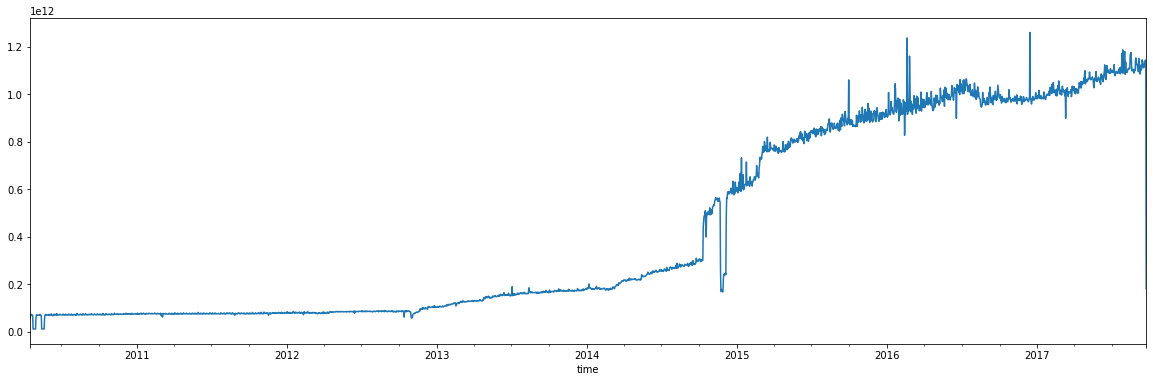

In [9]:
df['entries'].plot(figsize=(20,6))

# Gerando os dados sequenciais para a rede recorrente

In [10]:
series=df[['entries']]
series= series.head(series.shape[0]-1) ## excluindo o dia 2017-09-23  que possui dados inconpletos

janela= 14 # tamanho da janela deslizante utilizada -> N° de observações passadas
horizon=1  # horizonte de previsão

for i in range(0,janela):
    name= 'shihft_' + str(i+1)
    series[name]= series['entries'].shift(i+1)
    
series= series[series.columns[::-1]]   
series['Label']= series['entries'].shift(-horizon)
series=series.dropna()

# Divisão treino - teste cronológica

In [11]:
series['Label']=series['Label']/10000000000 #trabalhamos com o Label em menor escala para facilitar
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(series.drop(['Label'],axis=1), series[['Label']],
                                                    test_size=0.2, shuffle=False)

In [12]:
X_train.head(1)

,shihft_14,shihft_13,shihft_12,shihft_11,shihft_10,shihft_9,shihft_8,shihft_7,shihft_6,shihft_5,shihft_4,shihft_3,shihft_2,shihft_1,entries
time,,,,,,,,,,,,,,,
2010-05-01,5.812548e+10,7.077174e+10,7.382511e+10,7.234986e+10,7.054381e+10,6.904329e+10,7.020471e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,1.189887e+10,57030898125


In [13]:
y_test.tail(1)

,Label
time,
2017-09-21,112.07152


In [14]:
#Processando o dataframe para a aplicação do SVM
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X= (X_train.values)
Y= y_train.values
    
scaler.fit(X)
X= scaler.transform(X)

X2= (X_test.values)
X2= scaler.transform(X2)
    
Y2= y_test.values
print(X.shape)
print(X2.shape)

(2160, 15)
(541, 15)


In [15]:
from sklearn.svm import SVR
model= SVR(kernel='linear',C=1, epsilon=0.2)
model.fit(X, Y)

SVR(C=1, epsilon=0.2, kernel='linear')

In [16]:
predictions=model.predict(X2)
predictions_train=model.predict(X)

In [17]:
y_test['Pred']=predictions
y_train['Pred']=predictions_train

# Visualização das predições

<AxesSubplot:xlabel='time'>

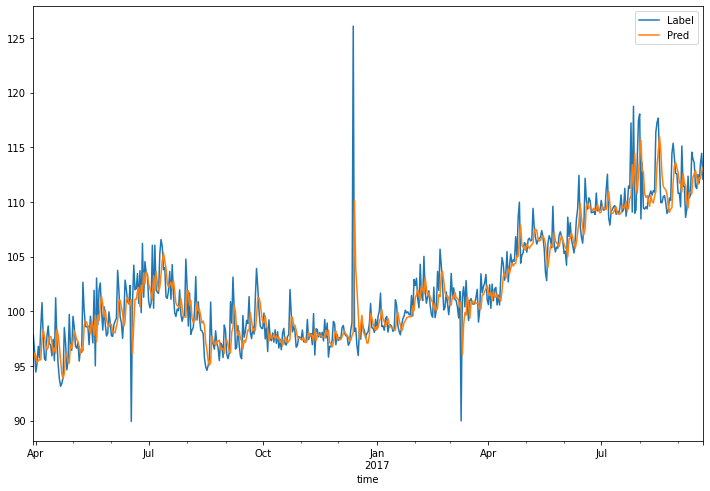

In [18]:
y_test.plot(figsize=(12,8))

In [19]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#erros nos dados de teste do SVM
print('MAPE: ',mean_absolute_percentage_error(y_test['Label'],y_test['Pred'])*100)
print('R2: ',r2_score(y_test['Label'],y_test['Pred']))
print('MSE: ',mean_squared_error(y_test['Label'],y_test['Pred']))

MAPE:  1.4480969982657534
R2:  0.8006099314111819
MSE:  5.820543801066832


In [22]:
#erros nos dados de treinamento do SVM
print('MAPE: ',mean_absolute_percentage_error(y_train['Label'],y_train['Pred'])*100)
print('R2: ',r2_score(y_train['Label'],y_train['Pred']))
print('MSE: ',mean_squared_error(y_train['Label'],y_train['Pred']))

MAPE:  2.8768195614411702
R2:  0.9957213737466365
MSE:  3.9410938798801074


Analisando os erros para treinamento e teste do SVM, verifica-se um bom desempenho em ambas as amostras.

In [24]:
Table=pd.concat([X_test/10000000000,y_test],axis=1)
Table['Mov_true']=Table['Label']-Table['entries']
Table['Mov_Pred']=Table['Pred']- Table['entries']

Table['Mov_true']  = np.where(Table['Mov_true']>0, 'Alta', 'Queda')
Table['Mov_Pred']  = np.where(Table['Mov_Pred']>0, 'Alta', 'Queda')

from sklearn.metrics import classification_report
print(classification_report(Table['Mov_true'], Table['Mov_Pred']))

              precision    recall  f1-score   support

        Alta       0.64      0.63      0.64       261
       Queda       0.66      0.68      0.67       280

    accuracy                           0.65       541
   macro avg       0.65      0.65      0.65       541
weighted avg       0.65      0.65      0.65       541



Calculo do acerto de direção nas previsões -> Não usual em regressão. No entanto, para séries financeiras é importante saber a capacidade do modelo em acertar a direção do mercado. No caso da série histórica do metrô também pode ser útil para indicar aumento ou diminuição no tráfego de pessoas.

#  Conclusão: O modelo SVM apresentou os melhores indicadores de erro e acurácia. A rede neural apesar de mais complexa exigiu muito processamento e tempo de treinamento. O modelo de support vector machine conseguiu um bom fitting com pouco processamento.  O Auto arima também atingiu bons resultados.